### Multiround UNL Attack Mixed

Figure 5abc, and 6c
Adjust the aggregation method accordingly based on hyperparameters (trimmed mean cutoff) to replicate results

Can also use this code to perform experiments for table 2

##### Summary
Load FAT model trained for 150 rounds and for 50 rounds try and inject FedAvg model into the system. Try different scaling rates and spread out the model replacement attack.

In [ ]:
cd to_base_directory

In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [6]:
setting, num_user = "FedAvg_adv", 40

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = "cifar10") # Indicate dataset here

# Load models for FAT and FedAvg
save_path_FAT = 'path_to_trained_FAT_weights'
save_path_FedAvg = 'path_to_trained_Fedavg_weights'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


100%|██████████| 80/80 [00:00<00:00, 143.73it/s]


===> Initializing clients..


100%|██████████| 80/80 [00:37<00:00,  2.12it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


In [7]:
# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key]

In [8]:
# Calculate uploaded model and download to attacker clients in aggregator
# Current version working under the assumption of close to convergence (no benign client pushback)
def calc_atk_model(model_inject, model_global, keys, weight_scale, weight_scale_2):

    atk_model = copy.deepcopy(model_global)
    inject_state_dict = model_inject.state_dict(keep_vars=True)
    global_state_dict = model_global.state_dict(keep_vars=True)
    return_state_dict = atk_model.state_dict(keep_vars=True)
    total_weight = weight_scale * weight_scale_2

    for key in keys:
        diff = inject_state_dict[key].data.clone() - global_state_dict[key].data.clone()
        return_state_dict[key].data = total_weight * diff + global_state_dict[key].data.clone()

    return atk_model

# Clone data from attack model to client model
def clone_model_weights(model_source, model_target, keys):
    target_state_dict = model_target.state_dict(keep_vars=True)
    source_state_dict = model_source.state_dict(keep_vars=True)
    
    for key in keys:
        target_state_dict[key].data = source_state_dict[key].data.clone()

    return

# Expand aggregator.mix() function
def UNL_mix(aggregator, adv_id, model_inject, keys, weight_scale_2, dump_flag=False, aggregation_op = None, tm_beta = 0.05):
    weight_scale = 1/aggregator.clients_weights
    model_global = aggregator.global_learners_ensemble[0].model

    if aggregation_op == None:
        aggregation_op = aggregator.aggregation_op
        
    # Based on aggregation methods change weight scale
    if aggregation_op == "median" or aggregation_op == "krum":
        weight_scale = np.ones(weight_scale.shape)



    # Give adversarial clients boosted models and train regular clients 1 round
    benign_id = list(range(len(aggregator.clients)))
    for a_id in adv_id:
        benign_id.remove(a_id)
        temp_atk_model = calc_atk_model(model_inject, model_global, keys, weight_scale[a_id], weight_scale_2)
        aggregator.clients[a_id].learners_ensemble[0].model = copy.deepcopy(temp_atk_model)

    for c_id in benign_id:
        aggregator.clients[c_id].step()

    # Aggregate model and download
    for learner_id, learner in enumerate(aggregator.global_learners_ensemble):
        learners = [client.learners_ensemble[learner_id] for client in aggregator.clients]
        if aggregation_op is None:
            average_learners(learners, learner, weights=aggregator.clients_weights)
        elif aggregation_op == 'median':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_median.pkl") 
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_median(
                learners, 
                learner, 
                dump_path=dump_path
            )
        elif aggregation_op == 'trimmed_mean':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_tm.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_tm(
                learners, 
                learner, 
                beta=tm_beta, 
                dump_path=dump_path
            )
        elif aggregation_op == 'krum':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_krum.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_krum(
                learners, 
                learner, 
                dump_path=dump_path
            )
        elif aggregation_op == 'krum_modelwise':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_krum_modelwise.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_krum_modelwise(
                1,
                learners,
                learner,
                dump_path=dump_path
            )
        else:
            raise NotImplementedError


    # assign the updated model to all clients
    aggregator.update_clients()

    aggregator.c_round += 1

    # if aggregator.c_round % aggregator.log_freq == 0:
    #     aggregator.write_logs()
    return 

In [44]:
num_aru = [5,10,20]
beta_params = [0.05,0.20,0.25]
weight2_list = [0.3,0.3,0.2]
num_rounds = 30

agg_options = ["trimmed_mean", "median", "krum"]

result_list = []
for itt in range(len(num_aru)):
    result_list += [{}]

setting, num_user = "FedAvg_adv", 40
save_path_FedAvg_150R = 'weights/cifar10/231031_FAT150round/FAT'
aggregator, clients, args_ = set_args(setting, num_user)

agg_choice = random.choices(range(3),k=num_rounds)

if True:
    print("updating adv data set")
    # add adv dataset update
    Fu = np.zeros(num_user)
    Fu[0:10] = 1

    # Setting evasion attack parameters
    x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
    x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 10,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)

    # Assign proportion and attack params
    for c in range(len(clients)):
        if Fu[c] > 0:
            aggregator.clients[c].set_adv_params(Fu[c], atk_params)
            aggregator.clients[c].update_advnn()
            aggregator.clients[c].assign_advdataset()

for itt in range(len(beta_params)):
    # Perform 50 rounds of FAT on FedAvg model 
    num_adv = num_aru[itt]
    weight2 = 1/num_adv * weight2_list[itt]
    adv_id = random.sample(range(10,num_user), num_adv) # excluding 0-9 as Fu = 1
    beta = beta_params[itt]

    test_acc_gather = []
    adv_acc_gather = []
    test_acc_std = []
    adv_acc_std = []
    cosine_gather_layers = np.zeros([num_rounds, len(desired_keys)])

    aggregator.tm_rate = beta

    # Test performance of aggregator on data 
    aggregator.load_state(dir_path = save_path_FedAvg_150R)
    aggregator.update_clients()
    model_FA = pull_model_from_agg(aggregator)
    model_FA.eval()
    acc, adv_acc = get_adv_acc(aggregator, model_FA)

    prev_model = copy.deepcopy(model_FA)

    print("Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
    test_acc_gather+= [np.mean(acc)]
    adv_acc_gather += [np.mean(adv_acc)]
    test_acc_std += [np.std(acc)]
    adv_acc_std += [np.std(adv_acc)]



    for i in range(num_rounds):

        # Per round Freq
        aggregator.aggregation_op = agg_options[agg_choice[i]]

        # aggregator.mix()
        UNL_mix(aggregator, adv_id, model_inject = model_Fedavg, keys = desired_keys, weight_scale_2 = weight2, dump_flag=False, tm_beta=beta)
        model_overfit = pull_model_from_agg(aggregator)
        model_overfit.eval()
        acc, adv_acc = get_adv_acc(aggregator, model_overfit)

        print("round", i,"Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
        test_acc_gather+= [np.mean(acc)]
        adv_acc_gather += [np.mean(adv_acc)]
        test_acc_std += [np.std(acc)]
        adv_acc_std += [np.std(adv_acc)]
        prev_model = copy.deepcopy(model_overfit)

        result_list[itt]['test_acc'] = copy.deepcopy(test_acc_gather)
        result_list[itt]['adv_acc'] = copy.deepcopy(adv_acc_gather)
        result_list[itt]['test_std'] = copy.deepcopy(test_acc_std)
        result_list[itt]['adv_std'] = copy.deepcopy(adv_acc_std)
        result_list[itt]['num_clients'] = num_adv
        result_list[itt]['beta'] = beta
        result_list[itt]['weight2'] = weight2_list[itt]
        # Perform gradient direction gathering

    

==> Clients initialization..
===> Building data iterators..


100%|██████████| 80/80 [00:00<00:00, 225.35it/s]


===> Initializing clients..


100%|██████████| 80/80 [00:30<00:00,  2.58it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


updating adv data set
Test acc:  0.7950000122189522 adv acc:  0.3375000063329935
round 0 Test acc:  0.8046875104308129 adv acc:  0.3425000045448542
round 1 Test acc:  0.7421875163912773 adv acc:  0.20937500502914191
round 2 Test acc:  0.6928125113248825 adv acc:  0.09437500208150595
round 3 Test acc:  0.6603125102818013 adv acc:  0.03343750066123903
round 4 Test acc:  0.7434375166893006 adv acc:  0.04406250077299774
round 5 Test acc:  0.7978125110268592 adv acc:  0.05281250067055225
round 6 Test acc:  0.8178125083446502 adv acc:  0.05093750096857548
round 7 Test acc:  0.8296875119209289 adv acc:  0.04812500120606274
round 8 Test acc:  0.8296875119209289 adv acc:  0.04843750095460564
round 9 Test acc:  0.8362500131130218 adv acc:  0.04625000092200935
round 10 Test acc:  0.846562510728836 adv acc:  0.040625000605359674
round 11 Test acc:  0.8303125098347663 adv acc:  0.0421875006519258
round 12 Test acc:  0.825000011920929 adv acc:  0.024687500414438547
round 13 Test acc:  0.852500012516

In [46]:
import pickle

a = result_list

with open('saved_results/mixed_sweep/240131_03_harder.pk', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# load relevant information and plot 
plot_settings = [[5,0.5],[10,0.5],[20,0.5]] # [num_aru, scale]

adv_acc_plotter1 = []
adv_std_plotter1 = []

# LINE NO 1
with open('saved_results/mixed_sweep/240130_01.pk', 'rb') as handle:
    loaded = pickle.load(handle)
adv_acc_plotter1 += [loaded[0]["adv_acc"]]
adv_std_plotter1 += [loaded[0]["adv_std"]]

# line no 2
adv_acc_plotter1 += [loaded[1]["adv_acc"]]
adv_std_plotter1 += [loaded[1]["adv_std"]]

# line no 3
adv_acc_plotter1 += [loaded[2]["adv_acc"]]
adv_std_plotter1 += [loaded[2]["adv_std"]]

adv_acc_plotter2 = []
adv_std_plotter2 = []

# LINE NO 1
with open('saved_results/mixed_sweep/240131_01.pk', 'rb') as handle:
    loaded = pickle.load(handle)
adv_acc_plotter2 += [loaded[0]["adv_acc"]]
adv_std_plotter2 += [loaded[0]["adv_std"]]

# line no 2
adv_acc_plotter2 += [loaded[1]["adv_acc"]]
adv_std_plotter2 += [loaded[1]["adv_std"]]

# line no 3
adv_acc_plotter2 += [loaded[2]["adv_acc"]]
adv_std_plotter2 += [loaded[2]["adv_std"]]

adv_acc_plotter3 = []
adv_std_plotter3 = []

# LINE NO 1
with open('saved_results/mixed_sweep/240131_02.pk', 'rb') as handle:
    loaded = pickle.load(handle)
adv_acc_plotter3 += [loaded[0]["adv_acc"]]
adv_std_plotter3 += [loaded[0]["adv_std"]]

# line no 2
adv_acc_plotter3 += [loaded[1]["adv_acc"]]
adv_std_plotter3 += [loaded[1]["adv_std"]]

# line no 3
adv_acc_plotter3 += [loaded[2]["adv_acc"]]
adv_std_plotter3 += [loaded[2]["adv_std"]]


adv_acc_plotter = []
adv_std_plotter = []

for i in range(len(adv_std_plotter2)):
    appended = np.zeros([3,len(adv_acc_plotter2[i])])
    appended[0], appended[1], appended[2]  = adv_acc_plotter1[i], adv_acc_plotter2[i],adv_acc_plotter3[i]
    adv_acc_plotter += [np.mean(appended,axis=0)]

    appended = np.zeros([3,len(adv_std_plotter2[i])])
    appended[0], appended[1],  appended[2]  = adv_std_plotter1[i], adv_std_plotter2[i], adv_std_plotter3[i]
    adv_std_plotter += [np.mean(appended,axis=0)]


In [7]:
with open('saved_results/mixed_sweep/240131_03_harder.pk', 'rb') as handle:
    result_list = pickle.load(handle)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


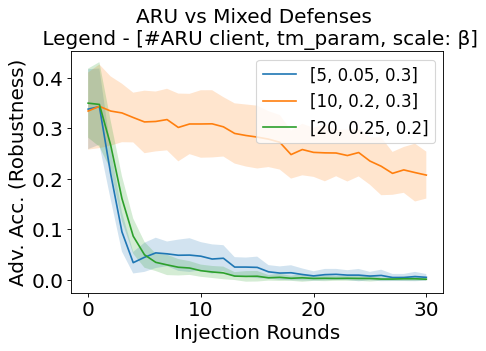

In [8]:
import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

plot_settings = [[5,0.05,0.3],[10,0.2, 0.3],[20,0.25, 0.2]]

num_aru = [5,10,20]
beta_params = [0.05,0.20,0.25]
weight2_list = [0.3,0.3,0.2]

# Generate some sample data
x = range(len(adv_acc_plotter[0]))  # 100 points from 0 to 10

# Plotting the lines
# plt.plot(x, y1, label='Test Acc')
label_list = plot_settings
for i in range(len(label_list)):
    y = np.array(result_list[i]['adv_acc'])
    error = np.array(result_list[i]['adv_std'])
    plt.plot(x, y, label= str(label_list[i]))
    plt.fill_between(x, y-error, y+error,
    alpha=0.2)

# Adding labels and title
plt.xlabel('Injection Rounds')
plt.ylabel('Adv. Acc. (Robustness)')
plt.title('ARU vs Mixed Defenses \n Legend - [#ARU client, tm_param, scale: β]', fontsize = 'medium')

# Adding a legend
plt.legend( loc=1, fontsize='small')


# Display the plot
plt.show()
